In [1]:
import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
nltk.download('punkt')
nltk.download('stopwords')

import string

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_score, recall_score, precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.model_selection import GridSearchCV

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\123\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\123\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [2]:
df = pd.read_csv('./data/labeled.csv')

In [3]:
df.shape

(14412, 2)

In [4]:
df.head(5)

,comment,toxic
0,"Верблюдов-то за что? Дебилы, бл...\r\n",1.0
1,"Хохлы, это отдушина затюканого россиянина, мол...",1.0
2,Собаке - собачья смерть\r\n,1.0
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1.0
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1.0


In [5]:
df['toxic'] = df['toxic'].apply(int)
df.head()


,comment,toxic
0,"Верблюдов-то за что? Дебилы, бл...\r\n",1
1,"Хохлы, это отдушина затюканого россиянина, мол...",1
2,Собаке - собачья смерть\r\n,1
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1


In [6]:
df['toxic'].value_counts()

0    9586
1    4826
Name: toxic, dtype: int64

In [7]:
# select only toxic comments and output only text of comments
for comment in df[df['toxic'] == 1]['comment'].head():
    print(comment)

Верблюдов-то за что? Дебилы, бл...

Хохлы, это отдушина затюканого россиянина, мол, вон, а у хохлов еще хуже. Если бы хохлов не было, кисель их бы придумал.

Собаке - собачья смерть

Страницу обнови, дебил. Это тоже не оскорбление, а доказанный факт - не-дебил про себя во множественном числе писать не будет. Или мы в тебя верим - это ты и твои воображаемые друзья?

тебя не убедил 6-страничный пдф в том, что Скрипалей отравила Россия? Анализировать и думать пытаешься? Ватник что ли?)



In [8]:
for comment in df[df['toxic'] == 0]['comment'].head():
    print(comment)

В шапке были ссылки на инфу по текущему фильму марвел. Эти ссылки были заменены на фразу Репортим брипидора, игнорируем его посты. Если этого недостаточно, чтобы понять, что модератор абсолютный неадекват, и его нужно лишить полномочий, тогда эта борда пробивает абсолютное дно по неадекватности.

Почитайте посты у этого автора,может найдете что нибудь полезное. Надеюсь помог) https: pikabu.ru story obyichnyie budni dezsluzhbyi 4932098

Про графику было обидно) я так то проходил все серии гта со второй части по пятую, кроме гта 4. И мне не мешала графика ни в одной из частей. На компе у меня было куча видеокарт. Начиная с 32мб RIVA TNT и заканчивая 2Гб 560Ti на которой я спокойно играю который год в танки, гта5, ведьмака3 купил на распродаже и начал проходить. Да, не на ультрах. С пониженными текстурами. И не мешает. Я не понимаю дрочева на графике, требовать графику уровня плойки 4 минимум. Мне надо чтобы глаза не резало, только и всего. По поводу управления, мне не хватает переходника

In [9]:
train_df, test_df = train_test_split(df, test_size=500)

In [10]:
test_df.shape

(500, 2)

In [11]:
test_df['toxic'].value_counts()

0    321
1    179
Name: toxic, dtype: int64

In [12]:
train_df['toxic'].value_counts()

0    9265
1    4647
Name: toxic, dtype: int64

# Data preparation for model

In [13]:
sentence_example = df.iloc[1]['comment'] # take text from comment with id 1
tokens = word_tokenize(sentence_example, language='russian') # split by spaces
tokens_without_punctuation = [i for i in tokens if i not in string.punctuation] # delete punctuation
russian_stop_words = stopwords.words('russian')
tokens_without_stopwords_and_punctuation = [i for i in tokens_without_punctuation if i not in russian_stop_words] # delete russian stopwords
snowball = SnowballStemmer(language='russian')
stemmed_tokens = [snowball.stem(i) for i in tokens_without_stopwords_and_punctuation] # make all words lowercase and delete endings of words

In [14]:
print(f'Исходный текст: {sentence_example}')
print('-------------------')
print(f'Токены: {tokens}')
print('-------------------')
print(f'Токены без пунктуации: {tokens_without_punctuation}')
print('-------------------')
print(f'Токены без пунктуации и стопслов: {tokens_without_stopwords_and_punctuation}')
print('-------------------')
print(f'Токены после стемминга: {stemmed_tokens}')
print('-------------------')

Исходный текст: Хохлы, это отдушина затюканого россиянина, мол, вон, а у хохлов еще хуже. Если бы хохлов не было, кисель их бы придумал.

-------------------
Токены: ['Хохлы', ',', 'это', 'отдушина', 'затюканого', 'россиянина', ',', 'мол', ',', 'вон', ',', 'а', 'у', 'хохлов', 'еще', 'хуже', '.', 'Если', 'бы', 'хохлов', 'не', 'было', ',', 'кисель', 'их', 'бы', 'придумал', '.']
-------------------
Токены без пунктуации: ['Хохлы', 'это', 'отдушина', 'затюканого', 'россиянина', 'мол', 'вон', 'а', 'у', 'хохлов', 'еще', 'хуже', 'Если', 'бы', 'хохлов', 'не', 'было', 'кисель', 'их', 'бы', 'придумал']
-------------------
Токены без пунктуации и стопслов: ['Хохлы', 'это', 'отдушина', 'затюканого', 'россиянина', 'мол', 'вон', 'хохлов', 'хуже', 'Если', 'хохлов', 'кисель', 'придумал']
-------------------
Токены после стемминга: ['хохл', 'эт', 'отдушин', 'затюкан', 'россиянин', 'мол', 'вон', 'хохл', 'хуж', 'есл', 'хохл', 'кисел', 'придума']
-------------------


In [15]:
snowball = SnowballStemmer(language='russian')
russian_stop_words = stopwords.words('russian')


def tokenize_sentence(sentence: str, remove_stop_words: bool = True):
    '''Split sentence, remove stop words, make stemming'''
    tokens = word_tokenize(sentence, language='russian')
    tokens = [i for i in tokens if i not in string.punctuation]
    if remove_stop_words:
        tokens = [i for i in tokens if i not in russian_stop_words]
    tokens = [snowball.stem(i) for i in tokens]
    return tokens


In [16]:
tokenize_sentence(sentence_example)

['хохл',
 'эт',
 'отдушин',
 'затюкан',
 'россиянин',
 'мол',
 'вон',
 'хохл',
 'хуж',
 'есл',
 'хохл',
 'кисел',
 'придума']

In [17]:
vectorizer = TfidfVectorizer(
    tokenizer=lambda x: tokenize_sentence(x, remove_stop_words=True))


In [18]:
features = vectorizer.fit_transform(train_df['comment'])


# Model training

In [19]:
model = LogisticRegression(random_state=0)
model.fit(features, train_df['toxic'])  # train model


LogisticRegression(random_state=0)

In [20]:
model.predict(features[0]) # predict class for first comment

array([0], dtype=int64)

In [36]:
# train_df['comment'].iloc[0] # 1 - negative comment, 0 - neutral
train_df['comment'].iloc[0]

'Я сам с Рязани , и я не хрена не понимал эту рекламу и что это значит\r\n'

In [22]:
model_pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(
        tokenizer=lambda x: tokenize_sentence(x, remove_stop_words=True))),
    ('model', LogisticRegression(random_state=0))
])


In [23]:
model_pipeline.fit(train_df['comment'], train_df['toxic'])

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(tokenizer=<function <lambda> at 0x000001DBEFF4BB80>)),
                ('model', LogisticRegression(random_state=0))])

In [24]:
model_pipeline.predict(["Привет, у меня все нормально"]) # 0 is neutral comment

array([0], dtype=int64)

In [25]:
model_pipeline.predict(['Слушай не пойти ли тебе нафиг отсуда?']) # 1 is negative comment

array([1], dtype=int64)

# Measuring metrics

Metrics:
1) Precision - probability, that comment that we tag as negative, actually negative
2) Recall - the ratio of bad comments found

In [26]:
precision_score(y_true=test_df['toxic'],
                y_pred=model_pipeline.predict(test_df['comment']))


0.9256198347107438

In [27]:
recall_score(y_true=test_df['toxic'],
             y_pred=model_pipeline.predict(test_df['comment']))


0.6256983240223464

Conslusion after first version of model:
1) Precision = 0.92
2) Recall = 0.62

# Improving model

Now, we will change probability threshold, to improve our metrics

In [38]:
prec, rec, thresholds = precision_recall_curve(
    y_true=test_df['toxic'],
    probas_pred=model_pipeline.predict_proba(test_df['comment'])[:, 1])


Make a plot of precision and recall ratio

c:\programming\studying\machine_learning\comment_classificator\comment_classificator_venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


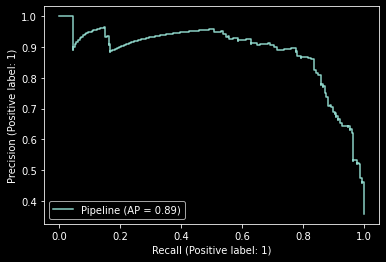

In [40]:
plot_precision_recall_curve(
    estimator=model_pipeline,
    X=test_df['comment'],
    y=test_df['toxic']
)


Let's find moments, where precision > 0.95

In [41]:
np.where(prec > 0.95)

(array([399, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416,
        417, 418, 419, 472, 473, 474, 475, 476, 477, 478, 479, 492, 493,
        494, 495, 496, 497, 498, 499, 500], dtype=int64),)

In [42]:
thresholds[399]

0.5842027901461968

In [44]:
precision_score(y_true=test_df['toxic'],
                y_pred=model_pipeline.predict_proba(test_df['comment'])[:, 1] > thresholds[399])


0.95

In [45]:
recall_score(y_true=test_df['toxic'],
             y_pred=model_pipeline.predict_proba(test_df['comment'])[:, 1] > thresholds[399])


0.5307262569832403

Conslusion after second version of model with probability threshold > 0.58
1) Precision = 0.95
2) Recall = 0.53

As we see above, if we change threshold (it's threshold of probability, with which logistic regression gives first(second) class) precision become more than 95% and recall become 53%

Now we have complete model, but there are opportunities to make our model more accurate

# Improving model part 2

Now, we will change parameter C (regularization strength) in our model to make model more accurate

In [ ]:
grid_pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(
        tokenizer=lambda x: tokenize_sentence(x, remove_stop_words=True))),
    ('model', GridSearchCV(
        estimator=LogisticRegression(random_state=0),
        # iter through several values of parameter C in LogisticRegression
        param_grid={'C': [0.1, 1, 10.]},
        cv=3,  # something of cross-validation
        verbose=4
    ))
])


In [29]:
grid_pipeline.fit(train_df['comment'], train_df['toxic'])
# what is score in output?

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV 1/3] END .............................C=0.1;, score=0.687 total time=   0.2s
[CV 2/3] END .............................C=0.1;, score=0.690 total time=   0.2s
[CV 3/3] END .............................C=0.1;, score=0.686 total time=   0.2s
[CV 1/3] END ...............................C=1;, score=0.834 total time=   0.4s
[CV 2/3] END ...............................C=1;, score=0.843 total time=   0.5s
[CV 3/3] END ...............................C=1;, score=0.839 total time=   0.4s


c:\programming\studying\machine_learning\comment_classificator\comment_classificator_venv\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/3] END ............................C=10.0;, score=0.867 total time=   0.9s


c:\programming\studying\machine_learning\comment_classificator\comment_classificator_venv\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/3] END ............................C=10.0;, score=0.873 total time=   0.9s


c:\programming\studying\machine_learning\comment_classificator\comment_classificator_venv\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/3] END ............................C=10.0;, score=0.861 total time=   0.8s


c:\programming\studying\machine_learning\comment_classificator\comment_classificator_venv\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(tokenizer=<function <lambda> at 0x000001DBEFF4BEE0>)),
                ('model',
                 GridSearchCV(cv=3,
                              estimator=LogisticRegression(random_state=0),
                              param_grid={'C': [0.1, 1, 10.0]}, verbose=4))])

Here we can see, that with C = 10 LogisticRegression have the largest score

In [46]:
model_pipeline_c_10 = Pipeline([
    ('vectorizer', TfidfVectorizer(
        tokenizer=lambda x: tokenize_sentence(x, remove_stop_words=True))),
    ('model', LogisticRegression(random_state=0, C=10))
])


In [47]:
model_pipeline_c_10.fit(train_df['comment'], train_df['toxic'])

c:\programming\studying\machine_learning\comment_classificator\comment_classificator_venv\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(tokenizer=<function <lambda> at 0x000001DBF2007DC0>)),
                ('model', LogisticRegression(C=10, random_state=0))])

In [49]:
prec_c_10, rec_c_10, thresholds_c_10 = precision_recall_curve(
    y_true=test_df['toxic'],
    probas_pred=model_pipeline_c_10.predict_proba(test_df['comment'])[:, 1])


In [50]:
np.where(prec_c_10 > 0.95)

(array([431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443,
        444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456,
        457, 458, 459, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476,
        477, 478, 479, 491, 492, 493, 494, 495, 496, 497, 498, 499, 500],
       dtype=int64),)

In [51]:
thresholds_c_10[431]

0.8848146980757583

In [54]:
precision_score(y_true=test_df['toxic'],
                y_pred=model_pipeline_c_10.predict_proba(test_df['comment'])[:, 1] > thresholds_c_10[431])

0.9558823529411765

In [55]:
recall_score(y_true=test_df['toxic'],
                y_pred=model_pipeline_c_10.predict_proba(test_df['comment'])[:, 1] > thresholds_c_10[431])

0.36312849162011174

Conslusion after making C = 10 in LogisticRegression
1) Precision = 0.95
2) Recall = 0.36

# Conclusion

Logistic Regression with default parameters:
1) Precision = 0.92
2) Recall 0.62

Logistic Regression with probability threshold 0.58
1) Precision = 0.95
2) Recall = 0.53

Logistic Regression with C = 10 (regularization strength) and probability threshold > 0.88
1) Precision = 0.95
2) Recall = 0.36